# Load and clean Dataset

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/oversampled_dataset_3labels.csv')

Log of datasets used

In [ ]:
# df=pd.read_csv('/content/ASAG_Similarity2.csv')
# df=pd.read_csv('/content/result_full.csv')
# df=pd.read_csv('/content/data_edited.csv')
# df=pd.read_csv('/content/dataset_cleaned.csv')
# df=pd.read_csv('/content/dataset_expaneded_2.csv')
# df=pd.read_csv('/content/dataset_3labels.csv')

In [ ]:
df=df.drop('Unnamed: 0', axis=1)

In [ ]:
df

In [ ]:
import re
PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace 

In [ ]:
def clean_text(text):
    text = text.lower() 
    # replace the matched string with ' '
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

In [ ]:
def clean_sentences(df):
    print('Cleaning sentences...')
    df['desired_answer'] = df['desired_answer'].apply(clean_text)
    df['student_answer'] = df['student_answer'].apply(clean_text)
    return df

In [ ]:
df = clean_sentences(df)

Cleaning sentences...


In [ ]:
df

# Install Hugging and datasets libraries

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets 

In [ ]:
from datasets import Dataset,DatasetDict

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
dataset.set_format("pt")

In [ ]:
dataset

Dataset({
    features: ['desired_answer', 'student_answer', 'label'],
    num_rows: 5259
})

# Load tokenizer and tokenize dataset

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["desired_answer"], examples["student_answer"], padding="max_length", truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5259
})

Split data into train and test

In [ ]:
train_test = tokenized_dataset.train_test_split(test_size=0.2)
train_test

DatasetDict({
    train: Dataset({
        features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4207
    })
    test: Dataset({
        features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1052
    })
})

See if there is any model answers that appear in both training and test datasets

In [ ]:
for a, b in zip(train_test['test']['desired_answer'],train_test['train']['desired_answer']):
  if a==b:
    print('yes')

yes
yes
yes
yes
yes


# visualize the data

In [ ]:
df_train = pd.DataFrame( valid_test['train'] )
df_test = pd.DataFrame( valid_test['test'] )

In [ ]:
df_train.to_csv('train_oversampled.csv')
df_test.to_csv('test_oversampled.csv')

In [ ]:
df_train['label']=df_train['label'].apply(lambda x:x.numpy())
df_test['label']=df_test['label'].apply(lambda x:x.numpy())

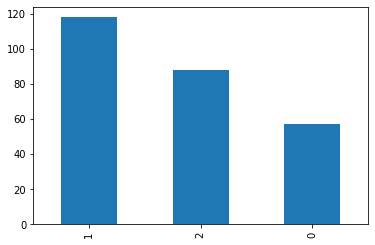

In [ ]:
pd.value_counts(df_train['label']).plot.bar()

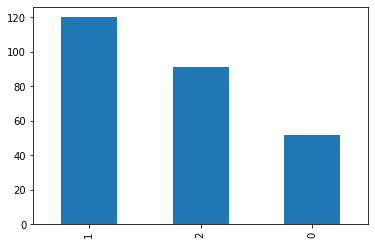

In [ ]:
pd.value_counts(df_test['label']).plot.bar()

# Download the model and start Training

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to("cuda")
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5).to("cuda")

In [ ]:
training_args = TrainingArguments(
    output_dir="./resultsv2",
    # learning_rate=1e-2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    optim="adafactor",
    num_train_epochs=36,
    # weight_decay=0.01,
    # metric_for_best_model='accuracy',
    fp16=True
)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
y_preds = []
y_trues = []

In [ ]:
def compute_metrics(eval_pred):
  pred, labels=eval_pred
  pred=np.argmax(pred,axis=1)

  acc=accuracy_score(labels,pred)
  f_score=f1_score(labels, pred, average='weighted')
  cohen_score = cohen_kappa_score(labels, pred)

  y_preds.append(pred)
  y_trues.append(labels)

  return {'acc':acc, 'f_score':f_score, 'cohen_score':cohen_score}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=train_test['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # optimizers=(optimizer, lr_scheduler)
)

Using cuda_amp half precision backend


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: student_answer, desired_answer. If student_answer, desired_answer are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4207
  Num Epochs = 36
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4752
  Number of trainable parameters = 66955779
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.394700
1000,0.090400
1500,0.038700
2000,0.025000
2500,0.014800
3000,0.013100
3500,0.012500
4000,0.010100
4500,0.010800


Saving model checkpoint to ./resultsv2/checkpoint-500
Configuration saved in ./resultsv2/checkpoint-500/config.json
Model weights saved in ./resultsv2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./resultsv2/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./resultsv2/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./resultsv2/checkpoint-1000
Configuration saved in ./resultsv2/checkpoint-1000/config.json
Model weights saved in ./resultsv2/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./resultsv2/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./resultsv2/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./resultsv2/checkpoint-1500
Configuration saved in ./resultsv2/checkpoint-1500/config.json
Model weights saved in ./resultsv2/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./resultsv2/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./resultsv

TrainOutput(global_step=4752, training_loss=0.06473358823394133, metrics={'train_runtime': 2572.5611, 'train_samples_per_second': 58.872, 'train_steps_per_second': 1.847, 'total_flos': 2.006281024660685e+16, 'train_loss': 0.06473358823394133, 'epoch': 36.0})

# Evaluate Model

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: student_answer, desired_answer. If student_answer, desired_answer are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1052
  Batch size = 32


{'eval_loss': 0.6528432369232178,
 'eval_acc': 0.9306083650190115,
 'eval_f_score': 0.9305416646922364,
 'eval_cohen_score': 0.8913791884131766,
 'eval_runtime': 5.9856,
 'eval_samples_per_second': 175.756,
 'eval_steps_per_second': 5.513,
 'epoch': 36.0}

# Confusion Matrix

In [ ]:
from keras.utils import to_categorical
num_classes = 5
y_categorial = to_categorical(y_preds, num_classes)
y_pred = y_categorial.argmax(1)

In [ ]:
y_trues_cat = to_categorical(y_trues, num_classes)
y_true=y_trues_cat.argmax(1)

In [ ]:
y_test_non_category = [int(np.argmax(t)) for t in y_trues_cat.tolist()[0] ]
y_predict_non_category = [ int(np.argmax(t)) for t in y_categorial.tolist()[0] ]

In [ ]:
confusion = confusion_matrix(y_test_non_category,y_predict_non_category)

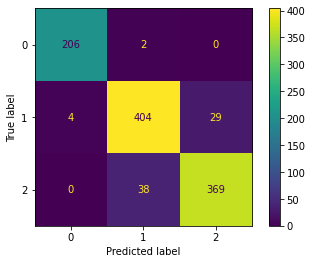

In [ ]:
import matplotlib.pyplot as plt
disp=ConfusionMatrixDisplay(confusion)
disp.plot()
plt.show()

In [ ]:
(38/1052) * 100 # 3.6 % error where the model gives an undesirved full grade

3.6121673003802277

# predict and save model

In [ ]:
model = model.to('cpu')
# model = model.to('cuda')

In [ ]:
inputs = tokenizer("A computer is a machine that can be programmed to carry out sequences of arithmetic or logical operations automatically", "I don't know", padding="max_length", truncation=True, return_tensors="pt")

In [ ]:
import torch
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_0'

In [ ]:
model.save_pretrained('/content/model')

Configuration saved in /content/model/config.json
Model weights saved in /content/model/pytorch_model.bin


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
model.push_to_hub('ASAG-Model')

Configuration saved in /tmp/tmptwlq_jla/config.json
Model weights saved in /tmp/tmptwlq_jla/pytorch_model.bin
Uploading the following files to khaled5321/ASAG-Model: pytorch_model.bin,config.json


CommitInfo(commit_url='https://huggingface.co/khaled5321/ASAG-Model/commit/7bf8632990d49c561015e5ffe375e507ecf2e2b5', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='7bf8632990d49c561015e5ffe375e507ecf2e2b5', pr_url=None, pr_revision=None, pr_num=None)